In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers, models

2025-09-04 09:15:00.879168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 09:15:00.916744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 09:15:01.850520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
root = "/home/nadeem/Downloads/Fan/fan/id_06"   # contains "normal" and "abnormal"


Class: Abnormal


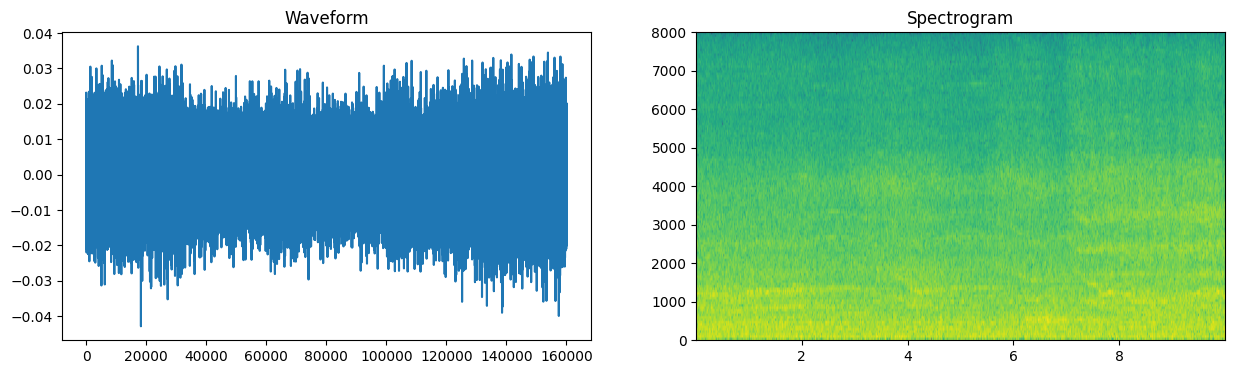

In [3]:
# Example abnormal file
audioFile = os.path.join(root, "abnormal", "00000029.wav")

waveform, sampleRate = librosa.load(audioFile, sr=None)  # sr=None keeps original sampling rate
print("Class: Abnormal")

# Play audio
ipd.display(ipd.Audio(waveform, rate=sampleRate))

# Plot waveform + spectrogram
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title("Waveform")

plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs=sampleRate)
plt.title("Spectrogram")

plt.show()


In [4]:
def extractFeatures(filePath, max_len=128):
    try:
        audio, sampleRate = librosa.load(filePath, sr=None)

        # Compute Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sampleRate, n_mels=128, fmax=8000
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure fixed size (time dimension may vary)
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode="constant")
        else:
            mel_spec_db = mel_spec_db[:, :max_len]

        return mel_spec_db

    except Exception as e:
        print(f"Error processing {filePath}: {e}")
        return None


In [5]:
target_folders = ["normal", "abnormal"]
data = []

for folder in target_folders:
    folderPath = os.path.join(root, folder)
    if not os.path.isdir(folderPath):
        continue

    for file in tqdm(os.listdir(folderPath), desc=f"Processing {folder}"):
        if not file.lower().endswith(".wav"):
            continue  # skip non-audio files

        filePath = os.path.join(folderPath, file)
        features = extractFeatures(filePath)
        if features is not None:
            data.append([features, folder])

data = pd.DataFrame(data, columns=["Features", "Class"])
print(data.head())



Processing abnormal: 100%|████████████████████| 361/361 [00:04<00:00, 89.63it/s]

                                            Features   Class
0  [[-21.122288, -19.70227, -20.632801, -18.11117...  normal
1  [[-12.385773, -7.721754, -5.8467155, -2.899780...  normal
2  [[-25.665955, -24.835598, -30.729889, -28.2206...  normal
3  [[-10.177108, -12.9441805, -16.888186, -14.173...  normal
4  [[-20.93615, -13.81166, -14.182593, -16.644125...  normal


In [6]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder   # <-- add this
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
# Step 5: Prepare data for training
# -----------------------------
X = np.array(data["Features"].tolist())   # shape (samples, 128, 128)
X = np.expand_dims(X, -1)                 # add channel → (samples, 128, 128, 1)

encoder = LabelEncoder()
y = encoder.fit_transform(data["Class"])
y = to_categorical(y)
print(encoder.classes_)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)

['abnormal' 'normal']


In [7]:
from tensorflow.keras import Sequential, layers, Input

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



/home/nadeem/anaconda3/envs/gpu_py/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756973718.979793   22129 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1144 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,218 (12.61 MB)

 Trainable params: 3,304,770 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10


2025-09-04 09:15:20.637329: I external/local_xla/xla/service/service.cc:163] XLA service 0x789c08004840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 09:15:20.637351: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
2025-09-04 09:15:20.673933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-04 09:15:20.879637: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-04 09:15:20.980919: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-04 09

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5391 - loss: 7.6465

I0000 00:00:1756973725.248405   22302 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6711 - loss: 4.8492

2025-09-04 09:15:29.767847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 20 bytes spill stores, 20 bytes spill loads



35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.7700 - loss: 2.4246 - val_accuracy: 0.7572 - val_loss: 3.5525
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9173 - loss: 0.2659 - val_accuracy: 0.3261 - val_loss: 8.7391
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9636 - loss: 0.0946 - val_accuracy: 0.7065 - val_loss: 1.2626
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9709 - loss: 0.0908 - val_accuracy: 0.7464 - val_loss: 1.3382
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9864 - loss: 0.0550 - val_accuracy: 0.9493 - val_loss: 0.1702
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9827 - loss: 0.0593 - val_accuracy: 0.9565 - val_loss: 0.1702
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9673 - loss: 0.1328 - val_accuracy: 0.9022 - val_loss: 0.4772
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9845 - loss: 0.0696 - val_accuracy: 0.9891 - val_loss: 

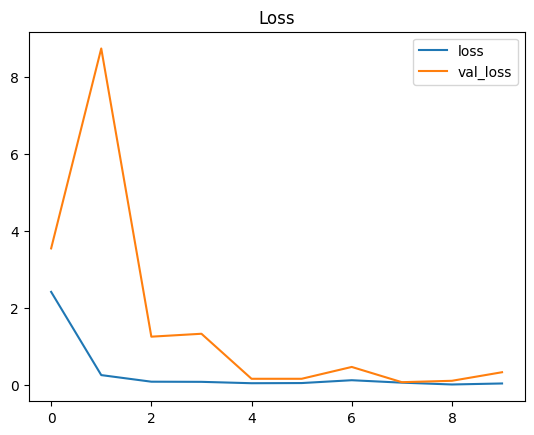

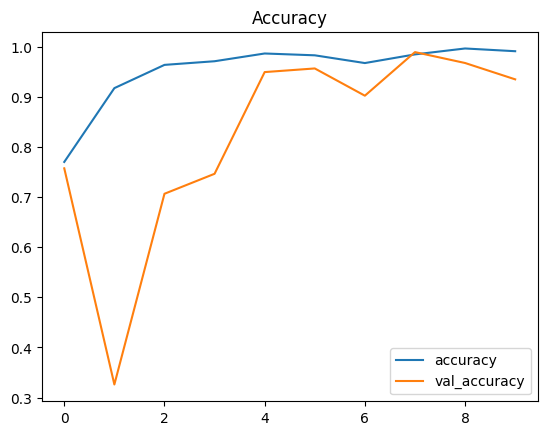

In [8]:
# -----------------------------
# Step 7: Train model
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(trainY.argmax(axis=1)),
    y=trainY.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))

historyDf=model.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=10, batch_size=32, class_weight=class_weights)





# -----------------------------
# Step 8: Plot training history
historyDf = pd.DataFrame(historyDf.history)
historyDf[['loss', 'val_loss']].plot(title="Loss")
historyDf[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()


In [9]:
# Evaluate accuracy and loss
test_loss, test_acc = model.evaluate(testX, testY, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


9/9 - 0s - 8ms/step - accuracy: 0.9348 - loss: 0.3402
Test Accuracy: 93.48%
Test Loss: 0.3402


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
              precision    recall  f1-score   support

    abnormal       1.00      0.76      0.86        74
      normal       0.92      1.00      0.96       202

    accuracy                           0.93       276
   macro avg       0.96      0.88      0.91       276
weighted avg       0.94      0.93      0.93       276



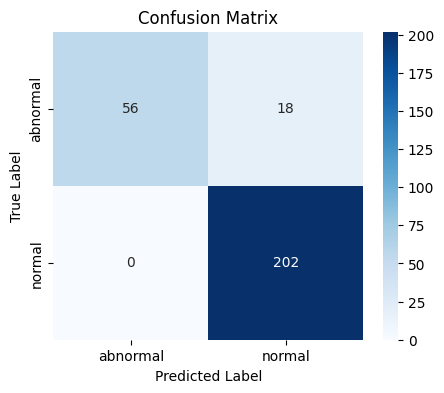

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [11]:
from tensorflow.keras.models import save_model
import joblib

# Save trained model
model.save("sound_1.h5")

# Save label encoder
joblib.dump(encoder, "sound_1.pkl")

print("✅ Model and encoder saved successfully.")


✅ Model and encoder saved successfully.


In [12]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, Input
import numpy as np

# 1. Load trained model (weights only)
old_model = load_model("sound_1.h5")

# 2. Define Functional model with explicit Input
inp = Input(shape=(128, 128, 1))
x = layers.Conv2D(32, (3,3), activation='relu')(inp)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

# 3. Transfer weights
model.set_weights(old_model.get_weights())

# 4. Verify
print("✅ Functional model rebuilt")
print("Input:", model.input)
print("Output:", model.output)

# Test with dummy data
dummy = np.zeros((1,128,128,1), dtype=np.float32)
pred = model.predict(dummy)
print("Dummy prediction:", pred)








✅ Functional model rebuilt
Input: <KerasTensor shape=(None, 128, 128, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_105>
Output: <KerasTensor shape=(None, 2), dtype=float32, sparse=False, ragged=False, name=keras_tensor_118>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Dummy prediction: [[1.0000000e+00 2.0325773e-23]]


In [13]:
# # Wrap the loaded Sequential model into a functional one
# model_func = tf.keras.Model(inputs=model.inputs, outputs=model.outputs)

# # Build grad_model using the functional wrapper
# grad_model = tf.keras.models.Model(
#     inputs=model_func.input,
#     outputs=[model_func.get_layer("conv2d_2").output, model_func.output]
# )



In [14]:
import random

def predict_samples_from_folder(folder, n=10):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".wav")]
    if len(files) == 0:
        print(f"No .wav files found in {folder}")
        return
    
    sampled_files = random.sample(files, min(n, len(files)))
    results = []

    for file in sampled_files:
        filePath = os.path.join(folder, file)
        features = extractFeatures(filePath)
        if features is None:
            print(f"Skipping {file} (feature extraction failed)")
            continue
        input_features = np.expand_dims(features, axis=(0, -1))

        prediction = model.predict(input_features, verbose=0).flatten()
        predicted_class = encoder.inverse_transform([np.argmax(prediction)])[0]
        probs = dict(zip(encoder.classes_, prediction))

        print(f"File: {file} → Predicted: {predicted_class}, Probabilities: {probs}")
        results.append((file, predicted_class, probs))

    return results



def predict_from_both(normal_folder, abnormal_folder, n=10):
    print("\n🔵 Predictions from NORMAL folder")
    normal_results = predict_samples_from_folder(normal_folder, n)

    print("\n🔴 Predictions from ABNORMAL folder")
    abnormal_results = predict_samples_from_folder(abnormal_folder, n)

    return normal_results, abnormal_results


In [15]:
print("Encoder classes:", encoder.classes_)


Encoder classes: ['abnormal' 'normal']


In [16]:
normal_path = "/home/nadeem/Downloads/normal"
abnormal_path = "/home/nadeem/Downloads/abnormal"

normal_preds, abnormal_preds = predict_from_both(normal_path, abnormal_path, n=10)



🔵 Predictions from NORMAL folder
File: 00000332.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 1.3642401e-13}
File: 00000228.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 2.552762e-11}
File: 00000188.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 8.1166616e-13}
File: 00000164.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 9.7425304e-11}
File: 00000368.wav → Predicted: abnormal, Probabilities: {'abnormal': 0.99999964, 'normal': 4.162131e-07}
File: 00000374.wav → Predicted: abnormal, Probabilities: {'abnormal': 0.99980736, 'normal': 0.00019264033}
File: 00000099.wav → Predicted: abnormal, Probabilities: {'abnormal': 0.9999194, 'normal': 8.055377e-05}
File: 00000252.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 1.0290732e-10}
File: 00000351.wav → Predicted: abnormal, Probabilities: {'abnormal': 1.0, 'normal': 3.4672412e-10}
File: 00000202.wav → Predicted: abnormal, Probabi

In [17]:
import os
import io
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, Input

# -----------------------------
# 1. Load & Rebuild Functional Model
# -----------------------------
old_model = load_model("sound_1.h5")

inp = Input(shape=(128, 128, 1))
x = layers.Conv2D(32, (3,3), activation='relu')(inp)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)
model.set_weights(old_model.get_weights())

print("✅ Functional model ready")

# -----------------------------
# 2. Grad-CAM Function
# -----------------------------
def get_gradcam_heatmap(img_array, model):
    # find last Conv2D layer dynamically
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    
    if last_conv_layer_name is None:
        raise ValueError("No Conv2D layer found in model.")
    print(f"Using last conv layer: {last_conv_layer_name}")

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]  # (H,W,C)
    weights = tf.reduce_mean(grads, axis=(0,1))   # (C,)
    cam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[0,:,:,i]

    cam = np.maximum(cam, 0)
    cam /= (cam.max() + 1e-8)
    return cam


# -----------------------------
# 3. Feature Extraction
# -----------------------------
def extractFeatures(filePath):
    try:
        audio, sr = librosa.load(filePath, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = librosa.util.fix_length(mel_spec_db, size=128, axis=1)  # ensure 128x128
        return mel_spec_db
    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

# -----------------------------
# 4. Gradio Prediction Function
# -----------------------------
classes = ["abnormal", "normal"]  # match your encoder.classes_

def predict_and_visualize(filePath):
    try:
        # --- Load audio ---
        audio, sr = librosa.load(filePath, sr=None)

        # --- Features ---
        features = extractFeatures(filePath)
        if features is None:
            return None, None, None, None, {"Error": 1.0}

        input_features = np.expand_dims(features, axis=(0, -1))

        # --- Prediction ---
        prediction = model.predict(input_features, verbose=0).flatten()
        label = classes[np.argmax(prediction)]

        # --- Waveform Plot ---
        plt.figure(figsize=(8, 2))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); waveform_img = Image.open(buf)

        # --- Spectrogram ---
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format='%+2.0f dB'); plt.title("Mel-Spectrogram (dB)")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); spectrogram_img = Image.open(buf)

        # --- Grad-CAM ---
        heatmap = get_gradcam_heatmap(input_features, model)
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.imshow(heatmap, cmap="jet", alpha=0.5, aspect="auto",
                   extent=[0, features.shape[1], 0, features.shape[0]])
        plt.colorbar(); plt.title(f"Grad-CAM ({label})")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); gradcam_img = Image.open(buf)

        return filePath, waveform_img, spectrogram_img, gradcam_img, {
            cls: float(p) for cls, p in zip(classes, prediction)
        }

    except Exception as e:
        print("Error in predict_and_visualize:", e)
        return None, None, None, None, {"Error": 1.0}

# -----------------------------
# 5. Gradio App
# -----------------------------
interface = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Audio(type="filepath", label="Upload a WAV file"),
    outputs=[
        gr.Audio(type="filepath", label="Playback"),
        gr.Image(type="pil", label="Waveform"),
        gr.Image(type="pil", label="Spectrogram"),
        gr.Image(type="pil", label="Grad-CAM Heatmap"),
        gr.Label(num_top_classes=2, label="Prediction")
    ],
    title="Normal vs Abnormal Sound Classifier with XAI",
    description="Upload a .wav file → See waveform, spectrogram, Grad-CAM explanation, and classification."
)

interface.launch()


✅ Functional model ready
* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


In [18]:
import os
import io
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import gradio as gr
import soundfile as sf

# -----------------------------
# Load model (Functional rebuild)
# -----------------------------
old_model = load_model("sound_1.h5")

inp = tf.keras.Input(shape=(128,128,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inp)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inp, outputs=out)
model.set_weights(old_model.get_weights())

print("✅ Functional model rebuilt, input/output defined")

# -----------------------------
# Grad-CAM
# -----------------------------
def get_gradcam_heatmap(input_img, model):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        raise ValueError("No Conv2D layer found.")

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_img)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]   # (H,W,C)
    weights = tf.reduce_mean(grads, axis=(0, 1))   # (C,)
    cam = tf.reduce_sum(conv_outputs[0] * weights, axis=-1)

    heatmap = np.maximum(cam, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    return heatmap

# -----------------------------
# Saliency Map
# -----------------------------
def get_saliency_map(input_img, model):
    input_tensor = tf.convert_to_tensor(input_img)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        preds = model(input_tensor)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, input_tensor)[0]
    saliency = np.abs(grads).max(axis=-1)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-9)
    return saliency

# -----------------------------
# Occlusion Sensitivity
# -----------------------------
def get_occlusion_map(input_img, model, patch_size=16):
    spectrogram = input_img[0, :, :, 0].copy()
    h, w = spectrogram.shape
    occlusion_map = np.zeros((h, w))
    baseline_pred = model.predict(input_img, verbose=0)[0]
    target_class = np.argmax(baseline_pred)

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            occluded = spectrogram.copy()
            occluded[i:i+patch_size, j:j+patch_size] = 0
            test_img = np.expand_dims(occluded, axis=(0, -1))
            new_pred = model.predict(test_img, verbose=0)[0]
            occlusion_map[i:i+patch_size, j:j+patch_size] = baseline_pred[target_class] - new_pred[target_class]

    occlusion_map = (occlusion_map - occlusion_map.min()) / (occlusion_map.max() - occlusion_map.min() + 1e-9)
    return occlusion_map

# -----------------------------
# Feature Extraction
# -----------------------------
def extractFeatures(filePath):
    try:
        audio, sr = librosa.load(filePath, sr=None)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
        return mel_db.astype(np.float32)
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# -----------------------------
# Operator-Friendly Explanations
# -----------------------------
def generate_textual_explanation(prediction, times, time_importance, threshold):
    label = classes[np.argmax(prediction)]
    conf = np.max(prediction) * 100

    abnormal_times = []
    for i in range(len(time_importance)):
        if time_importance[i] > threshold:
            t0 = times[i]
            t1 = times[i+1] if i+1 < len(times) else times[i]
            abnormal_times.append((round(t0,2), round(t1,2)))

    merged = []
    for t0, t1 in abnormal_times:
        if not merged or t0 - merged[-1][1] > 0.1:
            merged.append([t0, t1])
        else:
            merged[-1][1] = t1
    abnormal_ranges = ", ".join([f"{a}-{b}s" for a,b in merged]) if merged else "none"

    if conf < 60:
        return f"⚠️ Uncertain prediction. Model output: {label} ({conf:.2f}% confidence)."
    return f"Prediction: {label} ({conf:.2f}% confidence). Abnormality strongest at: {abnormal_ranges}."

def create_highlighted_audio(audio, sr, time_importance, threshold):
    duration = len(audio) / sr
    times = np.linspace(0, duration, len(time_importance))
    highlighted_audio = audio.copy()

    for i in range(len(time_importance)):
        t0 = int(times[i] * sr)
        t1 = int(times[i+1] * sr) if i+1 < len(times) else len(audio)
        if time_importance[i] <= threshold:
            highlighted_audio[t0:t1] *= 0.3

    temp_path = "temp_highlighted.wav"
    sf.write(temp_path, highlighted_audio, sr)
    return temp_path

# -----------------------------
# Prediction + Visualization
# -----------------------------
classes = ["abnormal", "normal"]

def predict_and_visualize(filePath):
    if filePath is None or not os.path.exists(filePath):
        return None, None, None, None, None, None, None, None, {"No file": 1.0}

    try:
        audio, sr = librosa.load(filePath, sr=None)
        duration = len(audio) / sr

        features = extractFeatures(filePath)
        if features is None:
            return None, None, None, None, None, None, None, None, {"Feature extraction failed": 1.0}
        input_features = np.expand_dims(features, axis=(0, -1))

        prediction = model.predict(input_features, verbose=0).flatten()
        probs = {cls: float(p) for cls, p in zip(classes, prediction)}
        label = classes[np.argmax(prediction)]

        heatmap = get_gradcam_heatmap(input_features, model)

        time_importance = np.mean(heatmap, axis=0)
        time_importance = (time_importance - time_importance.min()) / (time_importance.max() + 1e-9)
        threshold = np.percentile(time_importance, 70)
        times = np.linspace(0, duration, len(time_importance))

        text_explanation = generate_textual_explanation(prediction, times, time_importance, threshold)
        highlighted_audio_path = create_highlighted_audio(audio, sr, time_importance, threshold)

        # Waveform with highlights
        plt.figure(figsize=(8, 2))
        librosa.display.waveshow(audio, sr=sr)
        for i in range(len(time_importance)):
            if time_importance[i] > threshold:
                t0 = times[i]
                t1 = times[i+1] if i+1 < len(times) else times[i]
                plt.axvspan(t0, t1, color="red", alpha=0.3)
        plt.title(f"Waveform with Abnormal Regions ({label})")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); waveform_img = Image.open(buf)

        # Spectrogram
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format='%+2.0f dB'); plt.title("Mel-Spectrogram")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); spectrogram_img = Image.open(buf)

        # Grad-CAM
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.imshow(heatmap, cmap="jet", alpha=0.5, aspect="auto",
                   extent=[0, features.shape[1], 0, features.shape[0]])
        plt.title("Grad-CAM (Spectrogram)")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); gradcam_img = Image.open(buf)

        # Saliency
        saliency = get_saliency_map(input_features, model)
        plt.figure(figsize=(4, 4)); plt.imshow(saliency, cmap="hot", aspect="auto")
        plt.title("Saliency Map")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); saliency_img = Image.open(buf)

        # Occlusion
        occlusion = get_occlusion_map(input_features, model)
        plt.figure(figsize=(4, 4)); plt.imshow(occlusion, cmap="viridis", aspect="auto")
        plt.title("Occlusion Sensitivity")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); occlusion_img = Image.open(buf)

        # ✅ Return 9 outputs
        return (
            filePath,                     # Original audio
            highlighted_audio_path,       # Highlighted abnormal audio
            waveform_img,                 # Waveform
            spectrogram_img,              # Spectrogram
            gradcam_img,                  # Grad-CAM
            saliency_img,                 # Saliency
            occlusion_img,                # Occlusion
            probs,                        # Prediction dict
            text_explanation              # Explanation
        )

    except Exception as e:
        print(f"Error in predict_and_visualize: {e}")
        return None, None, None, None, None, None, None, None, {"Error": 1.0}

# -----------------------------
# Gradio App
# -----------------------------
interface = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Audio(type="filepath", label="Upload a WAV file"),
    outputs=[
        gr.Audio(type="filepath", label="Original Audio"),
        gr.Audio(type="filepath", label="Highlighted Abnormal Regions"),
        gr.Image(type="pil", label="Waveform + Abnormal Highlights"),
        gr.Image(type="pil", label="Spectrogram"),
        gr.Image(type="pil", label="Grad-CAM"),
        gr.Image(type="pil", label="Saliency"),
        gr.Image(type="pil", label="Occlusion"),
        gr.Label(num_top_classes=2, label="Prediction"),
        gr.Textbox(label="Explanation")
    ],
    title="Normal vs Abnormal Sound Classifier with Operator-Friendly Explanations",
    description="Upload a .wav file → Hear abnormal highlights, see waveform, spectrogram, XAI plots, and get a plain-English explanation."
)

interface.launch()


✅ Functional model rebuilt, input/output defined
* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


In [1]:
import os
import io
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import gradio as gr

# -----------------------------
# Load model (Functional rebuild)
# -----------------------------
old_model = load_model("sound_1.h5")

inp = tf.keras.Input(shape=(128,128,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inp)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inp, outputs=out)
model.set_weights(old_model.get_weights())

print("✅ Functional model rebuilt, input/output defined")

# -----------------------------
# Grad-CAM
# -----------------------------
def get_gradcam_heatmap(input_img, model):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        raise ValueError("No Conv2D layer found.")

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_img)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]   # (H,W,C)
    weights = tf.reduce_mean(grads, axis=(0, 1))   # (C,)
    cam = tf.reduce_sum(conv_outputs[0] * weights, axis=-1)

    heatmap = np.maximum(cam, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    return heatmap

# -----------------------------
# Feature Extraction
# -----------------------------
def extractFeatures(filePath):
    try:
        audio, sr = librosa.load(filePath, sr=None)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
        return mel_db.astype(np.float32)
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# -----------------------------
# Textual Explanation
# -----------------------------
def generate_textual_explanation(prediction, times, time_importance, threshold):
    label = classes[np.argmax(prediction)]
    conf = np.max(prediction) * 100

    abnormal_times = []
    for i in range(len(time_importance)):
        if time_importance[i] > threshold:
            t0 = times[i]
            t1 = times[i+1] if i+1 < len(times) else times[i]
            abnormal_times.append((round(t0,2), round(t1,2)))

    merged = []
    for t0, t1 in abnormal_times:
        if not merged or t0 - merged[-1][1] > 0.1:
            merged.append([t0, t1])
        else:
            merged[-1][1] = t1
    abnormal_ranges = ", ".join([f"{a}-{b}s" for a,b in merged]) if merged else "none"

    if conf < 60:
        return f"⚠️ Uncertain prediction. Model output: {label} ({conf:.2f}% confidence)."
    return f"Prediction: {label} ({conf:.2f}% confidence). Abnormality strongest at: {abnormal_ranges}."

# -----------------------------
# Prediction + Visualization
# -----------------------------
classes = ["abnormal", "normal"]

def predict_and_visualize(filePath):
    if filePath is None or not os.path.exists(filePath):
        return None, None, None, None, None, None, {"No file": 1.0}

    try:
        audio, sr = librosa.load(filePath, sr=None)
        duration = len(audio) / sr

        features = extractFeatures(filePath)
        if features is None:
            return None, None, None, None, None, None, {"Feature extraction failed": 1.0}
        input_features = np.expand_dims(features, axis=(0, -1))

        prediction = model.predict(input_features, verbose=0).flatten()
        probs = {cls: float(p) for cls, p in zip(classes, prediction)}
        label = classes[np.argmax(prediction)]

        heatmap = get_gradcam_heatmap(input_features, model)

        time_importance = np.mean(heatmap, axis=0)
        time_importance = (time_importance - time_importance.min()) / (time_importance.max() + 1e-9)
        threshold = np.percentile(time_importance, 70)
        times = np.linspace(0, duration, len(time_importance))

        text_explanation = generate_textual_explanation(prediction, times, time_importance, threshold)

        # ✅ Waveform with red/blue segments
        plt.figure(figsize=(10, 3))
        times_wave = np.linspace(0, duration, len(audio))
        for i in range(len(time_importance)):
            t0 = int(i * len(audio) / len(time_importance))
            t1 = int((i+1) * len(audio) / len(time_importance))
            if time_importance[i] > threshold:
                plt.plot(times_wave[t0:t1], audio[t0:t1], color="red")
            else:
                plt.plot(times_wave[t0:t1], audio[t0:t1], color="blue")
        plt.title(f"Waveform with Abnormal Regions ({label})")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); waveform_img = Image.open(buf)

        # Spectrogram
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format='%+2.0f dB'); plt.title("Mel-Spectrogram")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); spectrogram_img = Image.open(buf)

        # Grad-CAM overlay
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.imshow(heatmap, cmap="jet", alpha=0.5, aspect="auto",
                   extent=[0, features.shape[1], 0, features.shape[0]])
        plt.title("Grad-CAM (Spectrogram)")
        buf = io.BytesIO(); plt.savefig(buf, format="png"); plt.close()
        buf.seek(0); gradcam_img = Image.open(buf)

        return (
            filePath,            # Original audio
            waveform_img,        # Waveform (red = abnormal, blue = normal)
            spectrogram_img,     # Spectrogram
            gradcam_img,         # Grad-CAM
            probs,               # Prediction dict
            text_explanation     # Explanation
        )

    except Exception as e:
        print(f"Error in predict_and_visualize: {e}")
        return None, None, None, None, None, {"Error": 1.0}

# -----------------------------
# Gradio App
# -----------------------------
interface = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Audio(type="filepath", label="Upload a WAV file"),
    outputs=[
        gr.Audio(type="filepath", label="Original Audio"),
        gr.Image(type="pil", label="Waveform + Abnormal Highlights"),
        gr.Image(type="pil", label="Spectrogram"),
        gr.Image(type="pil", label="Grad-CAM"),
        gr.Label(num_top_classes=2, label="Prediction"),
        gr.Textbox(label="Explanation")
    ],
    title="Normal vs Abnormal Sound Classifier (Operator-Friendly)",
    description="Upload a .wav file → Hear the original audio, see waveform with abnormal regions in red, spectrogram, Grad-CAM overlay, and a plain-English explanation."
)

interface.launch()


2025-09-10 14:21:27.506144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 14:21:28.297698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 14:21:30.388517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1757510496.304150   13292 gpu_device.cc:2020] Created device /job:localhost/rep

✅ Functional model rebuilt, input/output defined
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


2025-09-10 14:22:00.334869: I external/local_xla/xla/service/service.cc:163] XLA service 0x713f80002f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 14:22:00.334882: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
2025-09-10 14:22:00.355876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 14:22:00.458382: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
I0000 00:00:1757510521.569030   13478 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Created dataset file at: .gradio/flagged/dataset2.csv


In [20]:
import os, io, json
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import gradio as gr

# -----------------------------
# Load trained model (functional rebuild)
# -----------------------------
old_model = load_model("sound_1.h5")

inp = tf.keras.Input(shape=(128,128,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inp)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inp, outputs=out)
model.set_weights(old_model.get_weights())
print("✅ Functional model rebuilt")

classes = ["abnormal", "normal"]

# -----------------------------
# Feature Extraction
# -----------------------------
def extractFeatures(filePath):
    audio, sr = librosa.load(filePath, sr=None)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
    return mel_db.astype(np.float32)

# -----------------------------
# Grad-CAM Heatmap
# -----------------------------
def get_gradcam_heatmap(input_img, model):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_img)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = tf.reduce_sum(conv_outputs[0] * weights, axis=-1)
    heatmap = np.maximum(cam, 0)
    return heatmap / (np.max(heatmap) + 1e-8)

# -----------------------------
# Saliency Map
# -----------------------------
def get_saliency_map(input_img, model):
    input_tensor = tf.convert_to_tensor(input_img)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        preds = model(input_tensor)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, input_tensor)[0]
    saliency = np.abs(grads).max(axis=-1)
    return (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-9)

# -----------------------------
# Occlusion Sensitivity
# -----------------------------
def get_occlusion_map(input_img, model, patch_size=16):
    spectrogram = input_img[0,:,:,0].copy()
    h, w = spectrogram.shape
    occlusion_map = np.zeros((h,w))
    baseline_pred = model.predict(input_img, verbose=0)[0]
    target_class = np.argmax(baseline_pred)
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            occluded = spectrogram.copy()
            occluded[i:i+patch_size, j:j+patch_size] = 0
            test_img = np.expand_dims(occluded, axis=(0,-1))
            new_pred = model.predict(test_img, verbose=0)[0]
            occlusion_map[i:i+patch_size, j:j+patch_size] = baseline_pred[target_class] - new_pred[target_class]
    return (occlusion_map - occlusion_map.min()) / (occlusion_map.max() - occlusion_map.min() + 1e-9)

# -----------------------------
# Explanation text
# -----------------------------
def generate_textual_explanation(prediction, times, time_importance, threshold):
    label = classes[np.argmax(prediction)]
    conf = np.max(prediction)*100
    abnormal_times=[]
    for i in range(len(time_importance)):
        if time_importance[i] > threshold:
            t0=times[i]; t1=times[i+1] if i+1<len(times) else times[i]
            abnormal_times.append((round(t0,2), round(t1,2)))
    merged=[]
    for t0,t1 in abnormal_times:
        if not merged or t0-merged[-1][1]>0.1:
            merged.append([t0,t1])
        else:
            merged[-1][1]=t1
    abnormal_ranges=", ".join([f"{a}-{b}s" for a,b in merged]) if merged else "none"
    if conf<60:
        return f"⚠️ Uncertain: {label} ({conf:.2f}%)."
    return f"Prediction: {label} ({conf:.2f}%). Abnormality strongest at: {abnormal_ranges}."

# -----------------------------
# Prediction + Visualization
# -----------------------------
def predict_and_visualize(filePath):
    if filePath is None or not os.path.exists(filePath):
        return None, "[]", None, None, None, None, None, {"No file": 1.0}, "No explanation"

    try:
        audio, sr = librosa.load(filePath, sr=None)
        duration = len(audio) / sr

        # Features
        features = extractFeatures(filePath)
        if features is None:
            return None, "[]", None, None, None, None, None, {"Error": 1.0}, "Feature extraction failed"

        input_features = np.expand_dims(features, axis=(0, -1))
        prediction = model.predict(input_features, verbose=0).flatten()
        probs = {cls: float(p) for cls, p in zip(classes, prediction)}
        label = classes[np.argmax(prediction)]

        # Grad-CAM
        heatmap = get_gradcam_heatmap(input_features, model)
        time_importance = np.mean(heatmap, axis=0)
        time_importance = (time_importance - time_importance.min()) / (time_importance.max() + 1e-9)
        threshold = np.percentile(time_importance, 70)
        times = np.linspace(0, duration, len(time_importance))

        # Abnormal regions
        abnormal_regions = []
        for i in range(len(time_importance)):
            if time_importance[i] > threshold:
                t0 = float(times[i])
                t1 = float(times[i+1]) if i+1 < len(times) else float(times[i])
                abnormal_regions.append([t0, t1])
        regions_json = json.dumps(abnormal_regions)

        # Explanation
        text_explanation = generate_textual_explanation(prediction, times, time_importance, threshold)

        # Waveform with highlights (matplotlib)
        plt.figure(figsize=(8, 2))
        librosa.display.waveshow(audio, sr=sr)
        for t0, t1 in abnormal_regions:
            plt.axvspan(t0, t1, color="red", alpha=0.3)
        plt.title(f"Waveform with Abnormal Regions ({label})")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0)
        waveform_img = Image.open(buf)

        # Spectrogram
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format='%+2.0f dB'); plt.title("Mel-Spectrogram")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0)
        spectrogram_img = Image.open(buf)

        # Grad-CAM overlay
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(features, sr=sr, x_axis="time", y_axis="mel")
        plt.imshow(heatmap, cmap="jet", alpha=0.5, aspect="auto",
                   extent=[0, features.shape[1], 0, features.shape[0]])
        plt.title("Grad-CAM (Spectrogram)")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0)
        gradcam_img = Image.open(buf)

        # Saliency
        saliency = get_saliency_map(input_features, model)
        plt.figure(figsize=(4, 4)); plt.imshow(saliency, cmap="hot", aspect="auto")
        plt.title("Saliency Map")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0)
        saliency_img = Image.open(buf)

        # Occlusion
        occlusion = get_occlusion_map(input_features, model)
        plt.figure(figsize=(4, 4)); plt.imshow(occlusion, cmap="viridis", aspect="auto")
        plt.title("Occlusion Sensitivity")
        buf = io.BytesIO()
        plt.savefig(buf, format="png"); plt.close()
        buf.seek(0)
        occlusion_img = Image.open(buf)

        # ✅ Return 9 values (matches Gradio)
        return (
            filePath,         # audio
            regions_json,     # hidden textbox
            waveform_img,     # waveform plot
            spectrogram_img,  # spectrogram
            gradcam_img,      # grad-cam
            saliency_img,     # saliency
            occlusion_img,    # occlusion
            probs,            # prediction dict
            text_explanation  # explanation
        )

    except Exception as e:
        print(f"Error in predict_and_visualize: {e}")
        return None, "[]", None, None, None, None, None, {"Error": 1.0}, "Error"


# -----------------------------
# Wavesurfer.js HTML player
# -----------------------------
waveform_html = """
<div id="waveform"></div>
<button onclick="wavesurfer.playPause()">▶️ / ⏸</button>
<script src="https://unpkg.com/wavesurfer.js"></script>
<script src="https://unpkg.com/wavesurfer.js/dist/plugin/wavesurfer.regions.min.js"></script>
<script>
function initWaveform(audioUrl, regions) {
    const wavesurfer = WaveSurfer.create({
        container: '#waveform',
        waveColor: 'blue',              // unplayed part
        progressColor: 'red',           // played part turns red
        height: 128,
        plugins: [ WaveSurfer.regions.create() ]
    });

    wavesurfer.load(audioUrl);

    // Add abnormal regions
    regions.forEach(r => {
        wavesurfer.addRegion({
            start: r[0],
            end: r[1],
            color: 'rgba(255,0,0,0.3)'   // translucent red overlay
        });
    });

    window.wavesurfer = wavesurfer;
}
</script>
"""

# -----------------------------
# Gradio App
# -----------------------------
# -----------------------------
# Gradio App
# -----------------------------
# -----------------------------
# Gradio App
# -----------------------------
with gr.Blocks() as demo:
    audio = gr.Audio(type="filepath", label="Original Audio")
    regions_out = gr.Textbox(visible=False)
    waveform_img = gr.Image(type="pil", label="Waveform + Abnormal Highlights")  # NEW
    spectrogram = gr.Image(type="pil", label="Spectrogram")
    gradcam = gr.Image(type="pil", label="Grad-CAM")
    saliency = gr.Image(type="pil", label="Saliency")
    occlusion = gr.Image(type="pil", label="Occlusion")
    probs_out = gr.Label(num_top_classes=2, label="Prediction")
    explanation_out = gr.Textbox(label="Explanation")
    html = gr.HTML(label="Interactive Waveform (with playback highlights)")

    # Function to render HTML waveform dynamically
    def update_waveform(filePath, regions_json, waveform_img, spectrogram_img, gradcam_img, saliency_img, occlusion_img, probs, explanation):
        return (
            filePath,                 # Original Audio
            waveform_img,             # Waveform image with highlights
            spectrogram_img,          # Spectrogram
            gradcam_img,              # Grad-CAM
            saliency_img,             # Saliency
            occlusion_img,            # Occlusion
            probs,                    # Prediction dict
            explanation,              # Text explanation
            f"""
            <div id="waveform"></div>
            <button onclick="wavesurfer.playPause()">▶️ / ⏸</button>
            <script src="https://unpkg.com/wavesurfer.js"></script>
            <script src="https://unpkg.com/wavesurfer.js/dist/plugin/wavesurfer.regions.min.js"></script>
            <script>
            initWaveform('{filePath}', {regions_json});
            </script>
            """   # HTML waveform with red abnormal regions
        )

    btn = gr.Button("Analyze")
    btn.click(
        predict_and_visualize,
        inputs=audio,
        outputs=[audio, regions_out, waveform_img, spectrogram, gradcam, saliency, occlusion, probs_out, explanation_out]
    ).then(
        update_waveform,
        inputs=[audio, regions_out, waveform_img, spectrogram, gradcam, saliency, occlusion, probs_out, explanation_out],
        outputs=[audio, waveform_img, spectrogram, gradcam, saliency, occlusion, probs_out, explanation_out, html]
    )

demo.launch()


✅ Functional model rebuilt
* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.
